In [19]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [20]:
# 데이터 불러오기
df = pd.read_csv('./datas/test_plan_featrues.csv')
user_df = pd.read_csv('./datas/test_user_plan_features.csv')

In [21]:
print(df.head())
print(user_df.head())

   planId          tagList                                       locationList  \
0       2          4 5 6 7  1(1, 2, 3), 10(2, 3, 8), 3(3, 5), 4(2, 3, 6, 7...   
1       3        8 9 10 11  12(1, 2, 3), 14(2, 3, 12, 13), 17(2, 3, 6, 7, ...   
2       4       7 12 13 14  1(1, 2, 3), 58(1, 2, 3), 59(2, 3), 60(2, 3, 26...   
3       5  1 2 15 16 17 18  27(1, 2, 3), 28(2, 3, 4), 29(16, 22), 30(23), ...   
4       6   19 20 21 22 23  100(16, 35), 71(1, 2, 3), 72(2, 3, 4), 73(2, 3...   

   durationDays  locationRatingAvg  likeCount  
0             3           4.512500          0  
1             4           4.200000          4  
2            30           4.485714          1  
3             9           4.415000          0  
4             7           4.438461         10  
   planId   tagList                                       locationList  \
0      16     4 6 7  1(1, 2, 3), 3(3, 5), 5(2, 3, 4), 7(3, 5), 9(2,...   
1      17   8 10 11  12(1, 2, 3), 17(2, 3, 6, 7, 17), 20(2, 3, 6, 7...   
2  

In [23]:
# TF-IDF: tagList
tfidf_tag = TfidfVectorizer()
tfidf_tag.fit(pd.concat([df['tagList'], user_df['tagList']]).astype(str))
tag_vec_df = tfidf_tag.transform(df['tagList'].astype(str)).toarray()
tag_vec_user = tfidf_tag.transform(user_df['tagList'].astype(str)).toarray()

In [24]:
# MultiLabel: locationId (괄호 앞 숫자 추출)
def extract_location_ids(col):
    return col.apply(lambda x: [item.split('(')[0] for item in str(x).split(', ')])

In [25]:
df_loc = extract_location_ids(df['locationList'])
user_loc = extract_location_ids(user_df['locationList'])

mlb_loc = MultiLabelBinarizer()
mlb_loc.fit(pd.concat([df_loc, user_loc]))
loc_vec_df = mlb_loc.transform(df_loc)
loc_vec_user = mlb_loc.transform(user_loc)

In [26]:
# Numeric
num_vec_df = df[['durationDays', 'locationRatingAvg']].fillna(0).values
num_vec_user = user_df[['durationDays', 'locationRatingAvg']].fillna(0).values

# 최종 벡터
final_vectors = np.hstack([tag_vec_df, loc_vec_df, num_vec_df])
user_vectors = np.hstack([tag_vec_user, loc_vec_user, num_vec_user])

# 병합
all_vectors = np.vstack([final_vectors, user_vectors])

In [27]:
# t-SNE
tsne = TSNE(n_components=2, perplexity=3, random_state=42)
vector_2d_tsne = tsne.fit_transform(all_vectors)

# 정규화 (0~1)
scaler = MinMaxScaler()
vector_2d_norm = scaler.fit_transform(vector_2d_tsne)

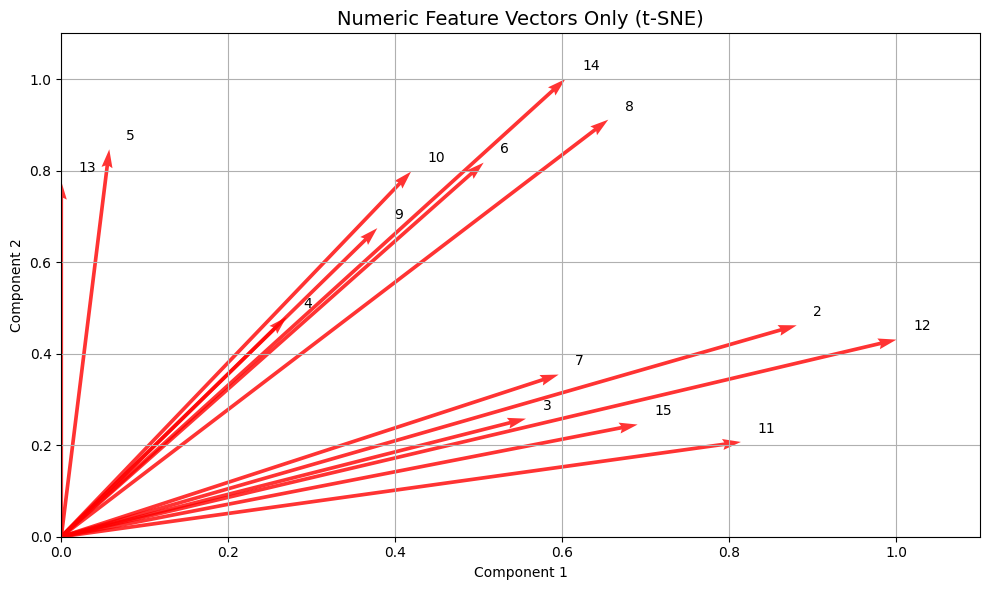

In [28]:
# 시각화
u = vector_2d_norm[:, 0]
v = vector_2d_norm[:, 1]
start_x = np.zeros_like(u)
start_y = np.zeros_like(v)

fig = plt.figure(figsize=(10, 6), dpi=100)
ax = fig.add_subplot(1, 1, 1)

# 기존 plan: 빨간색
ax.quiver(start_x[:len(df)], start_y[:len(df)], u[:len(df)], v[:len(df)],
          angles='xy', scale_units='xy', scale=1, color='red', alpha=0.8, width=0.004)

# planId 표시
all_plan_ids = list(df['planId']) 
for i, plan_id in enumerate(all_plan_ids):
    ax.text(u[i] + 0.02, v[i] + 0.02, str(plan_id), fontsize=10)

ax.set_xlim(0, 1.1)
ax.set_ylim(0, 1.1)
ax.set_title('Numeric Feature Vectors Only (t-SNE)', fontsize=14)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.grid(True)
plt.tight_layout()
plt.show()

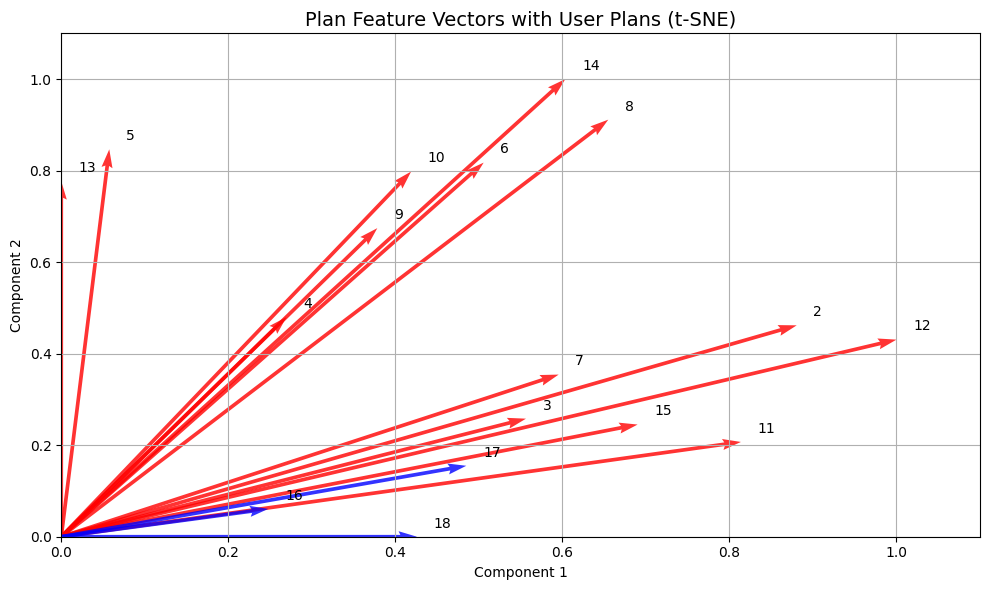

In [29]:
# 시각화
u = vector_2d_norm[:, 0]
v = vector_2d_norm[:, 1]
start_x = np.zeros_like(u)
start_y = np.zeros_like(v)

fig = plt.figure(figsize=(10, 6), dpi=100)
ax = fig.add_subplot(1, 1, 1)

# 기존 plan: 빨간색
ax.quiver(start_x[:len(df)], start_y[:len(df)], u[:len(df)], v[:len(df)],
          angles='xy', scale_units='xy', scale=1, color='red', alpha=0.8, width=0.004)

# 사용자 plan: 파란색
ax.quiver(start_x[len(df):], start_y[len(df):], u[len(df):], v[len(df):],
          angles='xy', scale_units='xy', scale=1, color='blue', alpha=0.8, width=0.004)

# planId 표시
all_plan_ids = list(df['planId']) + list(user_df['planId'])
for i, plan_id in enumerate(all_plan_ids):
    ax.text(u[i] + 0.02, v[i] + 0.02, str(plan_id), fontsize=10)

ax.set_xlim(0, 1.1)
ax.set_ylim(0, 1.1)
ax.set_title('Plan Feature Vectors with User Plans (t-SNE)', fontsize=14)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.grid(True)
plt.tight_layout()
plt.show()


In [30]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# final_vectors : 기존 df 벡터
# user_vectors  : user_df 벡터

# 유사도 계산 (user_plan vs 전체 plan)
similarity_matrix = cosine_similarity(user_vectors, final_vectors)

# 상위 5개 유사도 추출
top_k = 3
recommendations = []

for i, user_plan_id in enumerate(user_df['planId']):
    sim_scores = similarity_matrix[i]
    top_indices = sim_scores.argsort()[::-1][:top_k]
    
    for rank, idx in enumerate(top_indices):
        recommendations.append({
            'userPlanId': user_plan_id,
            'similarRank': rank + 1,
            'similarPlanId': df['planId'].iloc[idx],
            'similarityScore': round(sim_scores[idx], 4)
        })

# 결과 DataFrame
recommend_df = pd.DataFrame(recommendations)
print(recommend_df)


   userPlanId  similarRank  similarPlanId  similarityScore
0          16            1              2           0.9420
1          16            2             11           0.8367
2          16            3             12           0.7638
3          17            1              3           0.9107
4          17            2              7           0.8994
5          17            3             15           0.8931
6          18            1             15           0.8237
7          18            2             10           0.8214
8          18            3              9           0.8210


In [31]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# final_vectors : 기존 df 벡터
# user_vectors  : user_df 벡터

# 유사도 계산 (user_plan vs 전체 plan)
similarity_matrix = cosine_similarity(user_vectors, final_vectors)

# 전체 유사도 출력
recommendations = []

for i, user_plan_id in enumerate(user_df['planId']):
    sim_scores = similarity_matrix[i]
    
    for idx, score in enumerate(sim_scores):
        recommendations.append({
            'userPlanId': user_plan_id,
            'similarPlanId': df['planId'].iloc[idx],
            'similarityScore': round(score, 4)
        })

# 결과 DataFrame
recommend_df = pd.DataFrame(recommendations)
recommend_df.head()


,userPlanId,similarPlanId,similarityScore
0,16,2,0.9420
1,16,3,0.7274
2,16,4,0.6070
3,16,5,0.6977
4,16,6,0.6917


In [32]:
# 추천 결과에 likeCount 추가 (planId 기준 merge)
recommend_df = recommend_df.merge(df[['planId', 'likeCount']], 
                                  left_on='similarPlanId', 
                                  right_on='planId', 
                                  how='left')

# 컬럼 정리
recommend_df = recommend_df.drop(columns=['planId'])  # 중복 컬럼 제거
recommend_df = recommend_df.rename(columns={'likeCount': 'similarPlanLikeCount'})

# 유사도 → 좋아요 수 기준 정렬
recommend_df = recommend_df.sort_values(by=['userPlanId', 'similarityScore', 'similarPlanLikeCount'], 
                                        ascending=[True, False, False])


In [33]:
# 결과 확인
recommend_df.head()

,userPlanId,similarPlanId,similarityScore,similarPlanLikeCount
0,16,2,0.9420,0
9,16,11,0.8367,1
10,16,12,0.7638,2
5,16,7,0.7490,5
13,16,15,0.7349,9


In [ ]:
# 1. userPlanId별로 similarityScore가 큰 상위 4개 추출
top_k = 4
top_sim_df = (
    recommend_df
    .sort_values(by=['userPlanId', 'similarityScore'], ascending=[True, False])
    .groupby('userPlanId')
    .head(top_k)
)

# 2. 그 다음, likeCount 기준으로 정렬
top_sim_df = top_sim_df.sort_values(by=['userPlanId', 'similarPlanLikeCount'], ascending=[True, False])

top_sim_df.reset_index(drop=True, inplace=True)
top_sim_df


,userPlanId,similarPlanId,similarityScore,similarPlanLikeCount
0,16,7,0.7490,5
1,16,12,0.7638,2
2,16,11,0.8367,1
3,16,2,0.9420,0
4,17,15,0.8931,9
5,17,7,0.8994,5
6,17,3,0.9107,4
7,17,11,0.8123,1
8,18,10,0.8214,13
9,18,9,0.8210,12


In [39]:
recommend_df_like_sorted = top_sim_df.sort_values(by='similarPlanLikeCount', ascending=False).reset_index(drop=True)
recommend_df_like_sorted


,userPlanId,similarPlanId,similarityScore,similarPlanLikeCount
0,18,10,0.8214,13
1,18,9,0.8210,12
2,18,6,0.8147,10
3,17,15,0.8931,9
4,18,15,0.8237,9
5,17,7,0.8994,5
6,16,7,0.7490,5
7,17,3,0.9107,4
8,16,12,0.7638,2
9,16,11,0.8367,1
